In [ ]:
!pip install ket-lang
!pip install numpy
import numpy as np
import math
from ket import *

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


O FALQON foi proposto em 2021, e sua ideia central é controlar a evolução quântica de forma iterativa e adaptativa, isto é, com feedback contínuo do sistema. Ele tenta encontrar o estado quântico de menor energia (ou seja, a melhor solução para um problema de otimização) sem precisar de uma etapa de otimização clássica externa, o que é um grande problema no QAOA. Enquanto o QAOA alterna entre dois Hamiltonianos e ajusta parâmetros (ângulos) via um otimizador clássico, o FALQON faz isso automaticamente com um esquema de controle de feedback baseado em medições quânticas.

# Algoritmo Baseado em Feedback para Otimização Quântica Linear (FALQON)

O FALQON (*Feedback-based Algorithm for Quantum Optimization*) é um algoritmo quântico projetado para resolver problemas de otimização combinatória, utilizando controle por realimentação (feedback) para ajustar automaticamente a evolução do sistema quântico em direção à solução ótima.

Diferente de abordagens tradicionais que dependem de otimização clássica, o FALQON define um mecanismo de aprendizado interno, no qual o próprio sistema quântico coleta informações sobre seu estado e as usa para corrigir seu rumo dinamicamente. Buscando resolver problemas formulados como:

$$
minimizar \space C(z)
$$

Em que $C$ é a função custo que mede a precisão de cada solução e $z$ é uma configuração.

## Estrutura do Algorítmo

O FALQON se baseia em dois Hamiltonianos fundamentais:

* **Hamiltoniano de custo** ($H_c$), que representa o problema a ser otimizado.
* **Hamiltoniano de mistura** ($H_m$), que promove a transição entre diferentes estados do espaço de soluções.

A dinâmica total do sistema é dada por um **Hamiltoniano dependente do tempo**:

$$
H(t) = H_c + \beta(t) H_m
$$

onde $\beta(t)$ é um parâmetro de controle que varia ao longo do tempo e é continuamente atualizado a partir das medições feitas no sistema.

### Dinâmica de Evolução Temporal

```{note}
Essa parte é mais complicada, **principalmente se você não tem costume com a física**, foque em entender o conceito principal.
```

A dinâmica de evolução temporal do FALQON descreve como o estado quântico do sistema é modificado ao longo do tempo sob a influência de um Hamiltoniano dependente de um parâmetro de controle realimentado, $\beta(t)$.

Essa evolução é contínua no tempo, mas é frequentemente discretizada em intervalos finitos para implementação prática em circuitos quânticos.

#### Equação de Evolução

O sistema quântico é descrito por um vetor de estado $\ket{\psi(t)}$ que obedece à **equação de Schrödinger dependente do tempo**:

$$
i\frac{d}{dt}\ket{\psi(t)} = H(t)\ket{\psi(t)}
$$

onde o Hamiltoniano total é dado por:

$$
H(t) = H_c + \beta(t) H_m
$$

Nesse formalismo, $H_c$ é o **Hamiltoniano de custo**, responsável por atrair o sistema para estados de baixa energia (soluções boas), enquanto $H_m$ é o **Hamiltoniano de mistura**, que promove transições entre diferentes configurações.

O parâmetro $\beta(t)$ funciona como um **campo de controle dinâmico**, modulando a influência de $H_m$ ao longo do tempo.
A estratégia central do FALQON é ajustar $\beta(t)$ de forma a minimizar a energia esperada $\langle H_c \rangle$ durante a evolução.

#### Evolução Temporal Discretizada

Na prática, o tempo é dividido em pequenos intervalos $\Delta t$, de modo que a evolução pode ser aproximada por passos discretos:

$$
\ket{\psi_{k+1}} = e^{-i(H_c + \beta_k H_m)\Delta t} \ket{\psi_k}
$$

onde $\beta_k = \beta(t_k)$ é o valor do parâmetro de controle no instante $t_k$.

Após cada passo de evolução, o algoritmo realiza medições do valor esperado de $H_c$ no estado atual:

$$
\langle H_c \rangle_k = \bra{\psi_k} H_c \ket{\psi_k}
$$

Essas medições fornecem informações sobre a “energia atual” do sistema e permitem ajustar $\beta_k$ para o próximo passo.

#### Lei de Controle de Feedback

A atualização do parâmetro de controle é realizada segundo uma **lei de feedback** que visa diminuir continuamente o valor de $\langle H_c \rangle$:

$$
\beta_{k+1} = \beta_k - \eta \frac{d\langle H_c \rangle}{d\beta_k}
$$

onde $\eta$ é a **taxa de aprendizado** — um pequeno fator positivo que controla a intensidade da correção.

Fisicamente, essa relação expressa uma **descida adaptativa no espaço de controle**:
o sistema mede o impacto do parâmetro $\beta_k$ sobre a energia e o ajusta de modo a seguir a direção de menor energia esperada.

Em termos diferenciais, no limite contínuo, isso pode ser expresso como:

$$
\frac{d\beta(t)}{dt} = -\lambda \langle [H_m, H_c] \rangle_t
$$

onde $\lambda$ é uma constante de proporcionalidade e o termo $\langle [H_m, H_c] \rangle_t$ (o **valor esperado do comutador** entre $H_m$ e $H_c$) indica **como as duas partes do Hamiltoniano interferem dinamicamente**.
Esse termo é fundamental: ele quantifica **a taxa de variação da energia** em função da mistura induzida por $H_m$.

#### Interpretação Física

O mecanismo pode ser interpretado como um **sistema de controle em malha fechada**:

1. O estado $\ket{\psi(t)}$ evolui sob a ação do Hamiltoniano total.
2. Mede-se o valor esperado da energia do problema $\langle H_c \rangle_t$.
3. Essa medição alimenta a atualização do campo $\beta(t)$, que ajusta a dinâmica do sistema.
4. O processo se repete, guiando o sistema quântico em direção ao estado de energia mínima.

Dessa forma, o FALQON implementa uma espécie de **descida de energia supervisionada pelo próprio sistema**, sem dependência de um otimizador externo.

#### Convergência

Ao longo do tempo, a sequência de estados ${ \ket{\psi_k} }$ tende para uma configuração onde:

$$
\frac{d\langle H_c \rangle}{dt} \approx 0
$$

ou seja, a energia esperada se estabiliza, indicando que o sistema atingiu um **ponto fixo** — normalmente próximo ao **estado fundamental** de $H_c$.

Esse é o critério prático de convergência do algoritmo.

#### Implementação em Circuitos Quânticos

Na implementação experimental, a evolução exponencial $e^{-i(H_c + \beta_k H_m)\Delta t}$ é realizada por **sequências alternadas de portas quânticas**, usando a decomposição de Trotter-Suzuki:

$$
e^{-i(H_c + \beta_k H_m)\Delta t} \approx e^{-iH_c \Delta t} e^{-i\beta_k H_m \Delta t}
$$

Essa decomposição permite construir o circuito correspondente ao passo $k$ usando **blocos de portas controladas por $\beta_k$**, atualizadas após cada rodada de medições.

#### Conclusão

A dinâmica temporal do FALQON é caracterizada por um **controle adaptativo e contínuo**, no qual o sistema:

* evolui sob um Hamiltoniano dependente do tempo,
* mede seu próprio estado,
* e ajusta seu parâmetro de controle para reduzir a energia.

### Hamiltoniano de Custo (Cost)

O **hamiltoniano de custo** é o responsável por **codificar o problema de otimização** no sistema quântico.
Cada possível solução $z$ (uma sequência de bits) é associada a um valor de energia proporcional ao custo $C(z)$. O objetivo é encontrar o estado quântico que minimize essa energia esperada.

De modo geral, $H_c$ é **diagonal na base computacional**, e sua forma depende do problema que se deseja resolver.

Por exemplo, para o problema **Max-Cut**, o hamiltoniano de custo é dado por:

$$
H_c = \sum_{(i,j) \in E} \frac{1 - Z_i Z_j}{2}
$$

onde:

* $E$ é o conjunto de arestas do grafo,
* $Z_i$ e $Z_j$ são operadores de Pauli-Z aplicados aos qubits $i$ e $j$.

Esse termo atribui energia menor (ou custo maior) às configurações de bits que **maximizam o número de arestas “cortadas”**, ou seja, que conectam vértices em partições diferentes do grafo.

!!! FIGURA !!!
*(Sugestão: ilustração de um grafo simples com o corte (Max-Cut) destacado e a associação com os qubits via ( Z_iZ_j )).*

### Hamiltoniano de Mistura (Mixer)

O **hamiltoniano de mistura** tem o papel de **explorar o espaço de soluções**, permitindo que o sistema quântico escape de mínimos locais.

Ele é definido, de forma geral, como:

$$
H_m = \sum_{i} X_i
$$

onde $X_i$ é o operador de Pauli-X aplicado ao qubit $i$.

O operador $X_i$ realiza rotações entre os estados $\ket{0}$ e $\ket{1}$, ou seja, **muda os bits das soluções** de forma controlada pelos parâmetros $\beta$.
Assim, enquanto $H_c$ “atrai” o sistema para as boas soluções, $H_m$ garante diversidade e exploração — evitando que o algoritmo se prenda a uma única configuração.

# Aplicando FALQON no Max-Cut

O **FALQON** também pode ser ilustrado usando o problema do **Max-Cut**, um dos exemplos clássicos em otimização combinatória.
Nesse problema, buscamos **dividir os vértices de um grafo em dois conjuntos** de forma a **maximizar o número de arestas que conectam vértices de grupos diferentes**.

!!! FIGURA !!!
*(Sugestão: grafo dividido em dois grupos coloridos, mostrando as arestas cortadas — as que ligam vértices de cores diferentes.)*

## O Problema do Max-Cut

Dado um grafo $G = (V, E)$ com vértices $V$ e arestas $E$, queremos encontrar uma partição dos vértices $V$ em dois subconjuntos $S$ e $\bar{S}$ tal que o número de arestas entre eles seja máximo.

O custo clássico pode ser expresso como:

$$
C(z) = \sum_{(i,j)\in E} \frac{1 - z_i z_j}{2}
$$

onde $z_i, z_j \in {+1, -1}$ representam a qual subconjunto cada vértice pertence.

!!! FIGURA !!!
*(Sugestão: grafo com duas partições coloridas, ilustrando quais arestas são “cortadas”.)*

## FALQON em Max-Cut

O algoritmo inicia com o sistema no estado $\ket{+}^{\otimes n}$, representando uma **superposição uniforme** de todas as possíveis partições.
O Hamiltoniano de custo é definido como:

$$
H_C = \sum_{(i,j)\in E} \frac{1}{2}(I - Z_i Z_j)
$$

e o Hamiltoniano de mistura é geralmente tomado como:

$$
H_M = \sum_i X_i
$$

onde $Z_i$ e $X_i$ são os operadores de Pauli correspondentes a cada qubit.

A evolução temporal do estado segue a equação:

$$
\frac{d\ket{\psi(t)}}{dt} = -i \big[\beta(t) H_m + \gamma(t) H_c\big] \ket{\psi(t)}
$$

Aqui está a principal diferença do FALQON:
os parâmetros $\beta(t)$ e $\gamma(t)$ **não são otimizados por um loop clássico**, mas **ajustados dinamicamente** a cada passo de tempo, com base nas **medições do próprio sistema**.

O procedimento é o seguinte:

1. Mede-se a expectativa de $H_c$ no estado atual.
2. Essa medida serve de feedback para atualizar $\beta(t)$ e $\gamma(t)$ segundo uma regra de controle predefinida.
3. O sistema continua evoluindo, adaptando seus parâmetros até se aproximar do estado de menor energia, correspondente à melhor solução do Max-Cut.

!!! FIGURA !!!
*(Sugestão: esquema temporal mostrando a evolução do estado (|\psi(t)\rangle) sob feedback, com medições influenciando os parâmetros (\beta(t)) e (\gamma(t)).)*

## Simulação do Algoritmo Baseado em Feedback para Otimização Quântica Linear (FALQON) no Max-Cut

Para simular o FALQON usaremos a línguagem Ket de computação quântica, para isso precisamos ter ela instalada, caso não possua o pacote instalado rode o seguinte código:

```python
pip install ket-lang
```

Com a biblioteca instalada, importa-se para ser usada dentro do seu código:

In [1]:
from ket import *
from plotly import express as px

Primeiro definimos o hamiltoniano de custo ($H_c$)

In [2]:
def cost_h(edges, qubits):
    with obs():
        return -1 / 2 * sum(1 - Z(qubits[a]) * Z(qubits[b]) for a, b in edges)

Agora definimos o hamiltoniano de mistura ($H_m$)

In [3]:
def mixer_h(qubits):
    with obs():
        return sum(X(q) for q in qubits)

Depois disso, definimos o operador $\beta(t)$

In [4]:
def beta_h(arestas, qubits):
    h = 1j * commutator(mixer_h(qubits), cost_h(arestas, qubits))
    return -h

Criaremos a camada do FALQON, focando na evolução temporal

In [5]:
def falqon_layer(edges, delta_t, beta, qubits):
    evolve(cost_h(edges, qubits) * delta_t)
    evolve(mixer_h(qubits) * delta_t * beta)

Utilizando do ket, conseguimos plotar o circuito referente ao algoritmo

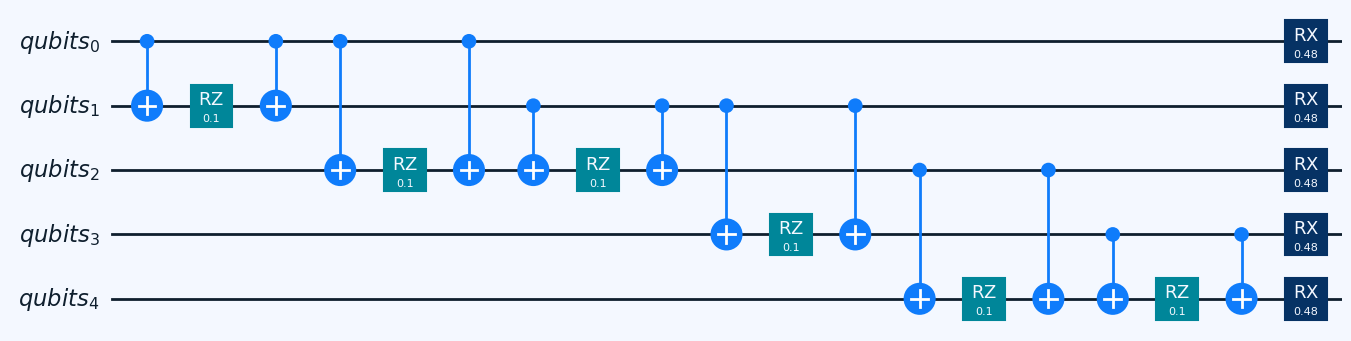

In [6]:
edges = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 4), (3, 4)]
num_nodes = len(edges) - 1

delta_t = 0.1

qulib.draw(falqon_layer, num_nodes, (edges, delta_t, 2.4))

Agora aplicamos o FALQON e plotamos os resultados

In [7]:
num_layers = 10

betas = [0.0]
cost = []

process = Process()
qubits = process.alloc(num_nodes)
H(qubits)

for _ in range(num_layers):
    falqon_layer(edges, delta_t, betas[-1], qubits)

    cost.append(exp_value(cost_h(edges, qubits)).get())
    betas.append(exp_value(beta_h(edges, qubits)).get())

sample(qubits).histogram("bin").show()

# Gráficos de custo e beta
px.line(x=list(range(len(cost))), y=cost, title="Cost").show()
px.line(x=list(range(len(betas))), y=betas, title="Beta").show()

# Aplicando FALQON ao QUBO

O FALQON é particularmente adequado para resolver problemas do tipo **QUBO** (*Quadratic Unconstrained Binary Optimization*), pois ele se baseia inteiramente no Hamiltoniano que codifica a função objetivo do problema e em um mecanismo de controle que ajusta a dinâmica quântica conforme o sistema evolui.

!!! FIGURA !!!
*(Sugestão: diagrama do circuito do QAOA, mostrando as camadas alternadas de $e^{-i\gamma H_c}$ e $e^{-i\beta H_m}$, com parâmetros ajustáveis.)*

## O que é o QUBO

O QUBO pode ser entendido como um problema onde buscamos um vetor binário $z = (z_1, z_2, ..., z_n)$, com cada $z_i \in {+1, -1}$, que minimize (ou maximize) uma função de custo quadrática da forma:

$$
C(z) = \sum_{i<j} w_{ij} z_i z_j + \sum_i w_i z_i
$$

onde $w_{ij}$ e $w_i$ são pesos associados às interações e aos vértices, respectivamente.

Um exemplo clássico é o **problema de Max-Cut**, onde o objetivo é dividir os vértices de um grafo em dois grupos de modo a maximizar o número de arestas entre eles. Nesse caso, o custo pode ser escrito como:

$$
C(z) = \sum_{(i,j)\in E} \frac{1 - z_i z_j}{2}
$$

!!! FIGURA !!!
*(Sugestão: grafo com vértices divididos em duas cores, destacando as arestas “cortadas” pela partição.)*

## FALQON ao QUBO

O FALQON resolve problemas QUBO convertendo a função de custo em um Hamiltoniano quântico e conduzindo o sistema através de uma evolução guiada por feedback.

* O **Hamiltoniano de Custo**, $H_c$, codifica a função objetivo do problema (no caso do Max-Cut, ele depende das arestas do grafo).
* O **Hamiltoniano Misturador**, $H_m$, atua sobre os qubits permitindo a exploração do espaço de soluções.

### Controle por Feedback

No FALQON, o parâmetro de controle é **$\beta(t)$**, ajustado dinamicamente a cada passo. Sua atualização segue uma regra de feedback baseada na estimativa quântica do comutador:

$$
\beta_{k+1} = \beta_k + \eta , \langle i[H_c, H_m] \rangle_k.
$$

### Evolução do Sistema

A evolução ocorre em passos discretos:

$$
\ket{\psi_{k+1}}

e^{-i \Delta t ( H_c + \beta_k H_m )}
\ket{\psi_k},
$$

fazendo o estado se aproximar de configurações com energia baixa de $H_c$.

### Leitura da Solução

No final, o estado é medido diversas vezes. Cada resultado $z$ é avaliado com $C(z)$, e o menor valor observado é tomado como a solução aproximada do QUBO.

!!! FIGURA !!!
*(Sugestão: diagrama híbrido mostrando o loop entre o computador quântico (geração do estado e medição) e o otimizador clássico (ajuste de parâmetros).)*


## Simulação do Algoritmo Baseado em Feedback para Otimização Quântica Linear (FALQON) ao QUBO

Para simular o FALQON usaremos a línguagem Ket de computação quântica, para isso precisamos ter ela instalada, caso não possua o pacote instalado rode o seguinte código:

```python
pip install ket-lang
```

Com a biblioteca instalada, importa-se para ser usada dentro do seu código:

In [9]:
from math import prod
from ket import *
from ket import ket_version
from pyqubo import Array
from plotly import express as px

Para implementar o FALQON no problema QUBO devemos primeiramente definir o portifólio

In [10]:
def portfolio(
    exp_return: list[float],
    cov_matrix: list[list[float]],
    budget: int,
    risk: float = 0.5,
    penalty: float = 1,
):
    if not (0 <= risk <= 1):
        raise ValueError("risk must be between 0 and 1")

    num_assets = len(exp_return)

    if num_assets != len(cov_matrix):
        raise ValueError(f"cov_matrix must be square {num_assets}x{num_assets}")

    if not (0 <= budget <= num_assets):
        raise ValueError(f"budget must be between 0 and {num_assets}")

    assets = Array.create("assets", shape=(num_assets,), vartype="BINARY")

    return -(
        sum(map(prod, zip(assets, exp_return)))
        - risk
        * sum(
            cov_matrix[i][j] * assets[i] * assets[j]
            for i in range(num_assets)
            for j in range(i + 1, num_assets)
        )
        - penalty * (budget - sum(assets)) ** 2
    )

Agora definimos os Hamiltonianos (mixel e custo), que já está nativamente no Ket, o $\beta(t)$ e suas camadas

In [11]:
cost_h = qulib.ham.qubo
mixer_h = qulib.ham.xy_mixer

def beta_h(arestas, qubits):
    h = 1j * commutator(mixer_h(qubits), cost_h(arestas, qubits))
    return -h

def falqon_layer(model, delta_t, beta, qubits):
    evolve(cost_h(model, qubits) * delta_t)
    evolve(mixer_h(qubits) * delta_t * beta)

Utilizando do ket, conseguimos plotar o circuito referente ao algoritmo

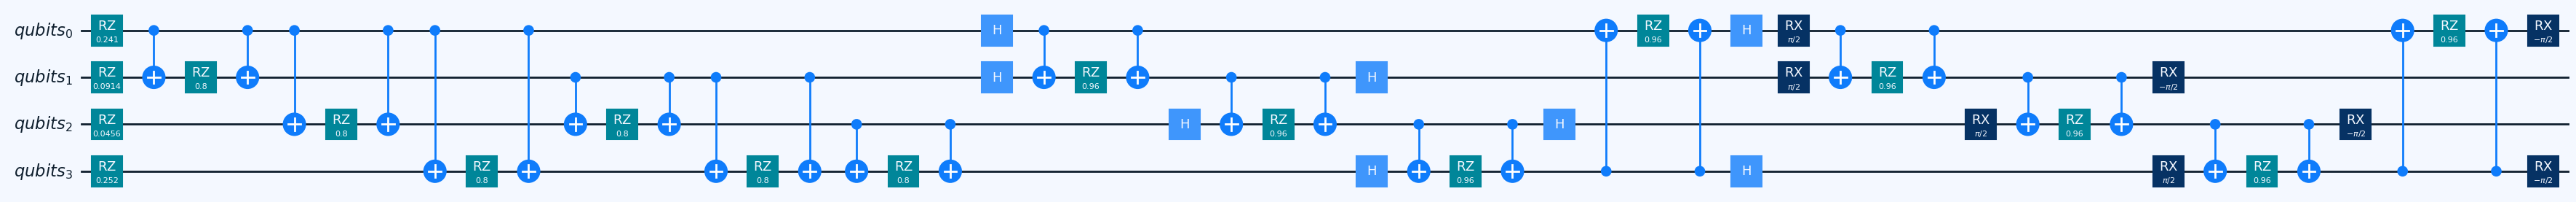

In [12]:
cov = [
    [1.08774352e-03, 2.59532811e-04, 1.80247155e-04, 3.21724369e-04],
    [2.59532811e-04, 4.43192629e-04, 7.43211072e-05, 2.27911525e-04],
    [1.80247155e-04, 7.43211072e-05, 3.89444953e-04, 1.37915422e-04],
    [3.21724369e-04, 2.27911525e-04, 1.37915422e-04, 8.75437564e-04],
]
mu = [0.31542042, 0.0571331, 0.11430001, 0.30109367]
h = portfolio(exp_return=mu, cov_matrix=cov, budget=2, risk=0.5)

model = h.compile()
delta_t = 0.8

qulib.draw(falqon_layer, 4, (model, delta_t, 1.2), fold=-1)

Assim, conseguimos plotar os resultados:

In [13]:
num_layers = 20

betas = [0.0]
cost = []

process = Process()
qubits = process.alloc(4)
H(qubits)

for _ in range(num_layers):
    falqon_layer(model, delta_t, betas[-1], qubits)

    cost.append(exp_value(cost_h(model, qubits)).get())
    betas.append(exp_value(beta_h(model, qubits)).get())

sample(qubits).histogram("bin").show()

# Gráficos de custo e beta
px.line(x=list(range(len(cost))), y=cost, title="Cost").show()
px.line(x=list(range(len(betas))), y=betas, title="Beta").show()

In [14]:
from dimod import ExactSolver

bqm = model.to_bqm()
sa = ExactSolver()
sampleset = sa.sample(bqm)
sampleset.to_pandas_dataframe().sort_values("energy")

,assets[0],assets[1],assets[2],assets[3],energy,num_occurrences
2,1,0,0,1,-0.616353,1
4,1,0,1,0,-0.429630,1
6,0,0,1,1,-0.415325,1
12,1,1,0,0,-0.372424,1
14,0,1,0,1,-0.358113,1
8,0,1,1,0,-0.171396,1
5,1,0,1,1,0.269506,1
13,1,1,0,1,0.326757,1
11,1,1,1,0,0.513404,1
9,0,1,1,1,0.527693,1
